In [4]:
#Note that the notebook was originally made in google Colab, please make use of the google colab notebook: see link in End_Report.pdf

#%pip install pandas
#%pip install pycountry_convert
#%pip install rich
%reload_ext google.colab.data_table

import pandas as pd
import numpy as np
import math, random, datetime
#from google.colab import data_table
#import pycountry_convert as pc

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

from rich import print as rprint
from rich.panel import Panel
from rich.rule import Rule

from sklearn.linear_model import LinearRegression

ModuleNotFoundError: No module named 'google'

In [34]:
## Reading csv files

df1 = pd.read_csv(r'co-emissions-per-capita.csv')
df2 = pd.read_csv(r'gdp-per-capita-maddison.csv')
df3 = pd.read_csv(r'per-capita-energy-stacked.csv')
df4 = pd.read_csv(r'electricity-statistics-by region-technology.csv')


In [35]:
# Sources
"""
df1, Global Carbon Budget (2023); Population based on various sources (2023) – with major processing by Our World in Data
https://ourworldindata.org/grapher/co-emissions-per-capita

df2, GDP per Capita - Bolt and van Zanden - Maddison Project Database 2023 – with minor processing by Our World in Data
https://ourworldindata.org/grapher/gdp-per-capita-maddison

df3, Per capita primary energy consumption by source, 2023 by Our World in Data
https://ourworldindata.org/grapher/per-capita-energy-stacked

df4, Electricity statistics (MW/GWh) by Region, Technology, Data Type and Year
IRENASTAT Online Data Query Tool by International Renewable Energy Agency (IRENA)
https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/
"""


'\ndf1, Global Carbon Budget (2023); Population based on various sources (2023) – with major processing by Our World in Data\nhttps://ourworldindata.org/grapher/co-emissions-per-capita\n\ndf2, GDP per Capita - Bolt and van Zanden - Maddison Project Database 2023 – with minor processing by Our World in Data\nhttps://ourworldindata.org/grapher/gdp-per-capita-maddison\n\ndf3, Per capita primary energy consumption by source, 2023 by Our World in Data\nhttps://ourworldindata.org/grapher/per-capita-energy-stacked\n\ndf4, Electricity statistics (MW/GWh) by Region, Technology, Data Type and Year\nIRENASTAT Online Data Query Tool by International Renewable Energy Agency (IRENA)\nhttps://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/\n'

## Function Body

In [36]:
# Functions for exploration, uniques, missing and null

# Printing seperator
def print_separator(msg, style):
  rprint(Panel(Rule(style=style),  title=msg, border_style="bold", style=style))

#print_separator("-", "short_separator_amount", "Frequencies")

# Unique Values
def look_at_unique_values(column):
  unique_values_cutoff = 220
  unique_values = column.unique()
  num_unique_values = len(unique_values)
  if num_unique_values <= unique_values_cutoff:
    print(f"""Qty of unique values = {num_unique_values}\n
          Unique values: {unique_values}""")
  else:
    print(f"""Warning! more then {unique_values_cutoff} unique values,\n
              total qty of unique values: {num_unique_values}\n
              reset cutoff value if needed""")

# Looking at Edges start and end of columns
def look_at_edges(df, column_name):                                             #Look at the edges to find outliers of column
    num_items_to_slice = 10
    display(df[column_name].head(num_items_to_slice))
    display(df[column_name].tail(num_items_to_slice))

# IQR To see bounds of values
def IQR_outlier(df, column):
    if not pd.api.types.is_numeric_dtype(df[column]):
        display(f"Column '{column}' is not numerical, skipping IQR calculation.")
        return  # Exit the function early

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    print(f"Q1 = {Q1}, Q3 = {Q3}")
    IQR = Q3 - Q1
    upper_bound = (Q3 + 1.5 * IQR).round(2)
    lower_bound = (Q1 - 1.5 * IQR).round(2)
    if lower_bound < 0:
        lower_bound = 0
    print(f"""Lower_bound = {float(lower_bound)}, upper_bound = {float(upper_bound)}""")

def check_nulls(df, column_name, n):
  sorted_values = sorted(df[column_name].unique())
  display("Head:", sorted_values[:n])
  display("Tail:", sorted_values[-n:])

def secondary_check_nulls(df, column_name):

    value_counts = df[column_name].value_counts(dropna=False)
    null_check_df = pd.DataFrame({
        'Value': value_counts.index,
        'Count': value_counts.values
    })
    null_check_df = null_check_df.sort_values(by=['Count'], ascending=False)
    null_check_df.index.name = 'Rank'
    null_check_df.reset_index(inplace=True)

    return display(null_check_df)

def dataset_unique_values(df):
    colors = ['red', 'green', 'blue', 'yellow', 'magenta']
    for i, column in enumerate(df):
        print_separator(f"Column = {column}", colors[i % len(colors)])
        secondary_check_nulls(df, column)

def dataset_exploration(df):
   print_separator(f"Some exploration of the dataset", "Green")
   display(df.describe().round(2))
   dataset_unique_values(df)

def column_exploration(df, column_name):
  print_separator(f"Some exploration of column: {column_name}", "Green")
  column = df[column_name]
  # Overview
  display(column.describe().round(2))
  # Unique Values
  print_separator("Unique Values", "Blue")
  look_at_unique_values(column)
  # Looking at the Edges
  print_separator("Looking at the edges", "Magenta")
  look_at_edges(df, column_name)
  # Check Non default nulls
  print_separator("Check for Non Default missing values", "Yellow")
  secondary_check_nulls(df, column_name)
  # Looking at the frequencies of each value
  print_separator("Frequencies", "Red")
  display(column.value_counts(dropna=False, ascending=False))
  # IQR Bounds
  print_separator("IQR Bounds", "Purple")
  #if pd.api.types.is_numeric_dtype(df[column_name]):
  IQR_outlier(df, column_name)


## Main Body

In [37]:
## 1st dataset

def clean_data1(df):
  # Drop missing data
  df = df.dropna()
  # Renaming
  df = df.rename(columns={'Annual CO₂ emissions (per capita)': 'Annual_CO2', 'Entity': 'Country'})
  # Filtering between 1950 <= 2020
  df = df[(df['Year'] >= 1990) & (df['Year'] <= 2020)]
  # Dropping code column
  df = df.drop(columns=['Code'])
  # Rounding to 3 decimal
  df = df.round({'Annual_CO2': 3})
  # Remove World samples
  df = df[df['Country'] != 'World']
  return df

df_CO2 = clean_data1(df1.copy())
#df_CO2.info()

In [38]:
## 2nd dataset

def clean_data2(df):
  # Drop column
  df = df.drop(columns=['900793-annotations'])
  # Drop missing values
  df = df.dropna()
  # Filter on years
  df = df[(df['Year'] >= 1990) & (df['Year'] <= 2020)]
  # Rounding GDP
  df = df.round({'GDP per capita': 2})
  # Drop country code column
  df = df.drop(columns=['Code'])
  # Rename column
  df = df.rename(columns={'Entity': 'Country'})
  # Remove World from list of countries
  df = df[df['Country'] != 'World']
  return df

df_GDP = clean_data2(df2.copy())
#df_GDP.info()
#display(df_GDP)


In [39]:
## 3rd dataset
def clean_data3(df):
  # Renaming with dictionary
  new_names = {'Entity': 'Country',
               'Coal per capita (kWh)': 'Coal_Cap_kWh',
               'Oil per capita (kWh)': 'Oil_Cap_kWh',
               'Gas per capita (kWh)': 'Gas_Cap',
               'Nuclear per capita (kWh - equivalent)': 'Nuclear_Cap_kWh',
               'Hydro per capita (kWh - equivalent)': 'Hydro_Cap_kWh',
               'Wind per capita (kWh - equivalent)': 'Wind_Cap_kWh',
               'Solar per capita (kWh - equivalent)': 'Solar_Cap_kWh',
               'Other renewables per capita (kWh - equivalent)': 'Other_Cap_kWh'}
  df = df.rename(columns=new_names)
  # Drop missing values
  df = df.dropna()
  # Drop column
  df = df.drop(columns=['Code'])
  # Rounding off values
  df = df.round({'Coal_Cap_kWh': 2, 'Oil_Cap_kWh': 2,
                               'Gas_Cap': 2, 'Nuclear_Cap_kWh': 2,
                               'Hydro_Cap_kWh' : 2, 'Wind_Cap_kWh': 2,
                               'Solar_Cap_kWh': 2})
  # Filter on years
  df = df[(df['Year'] >= 1990) & (df['Year'] <= 2020)]
  # Removing world from list of countries
  df = df[df['Country'] != 'World']
  # Creating Fossil and renewable capacity columns
  df['Fossil_Cap_kWh'] = (df['Coal_Cap_kWh'] + df['Oil_Cap_kWh'] + df['Gas_Cap']).round(2)
  df['Renewable_Cap_kWh'] = (df['Nuclear_Cap_kWh'] + df['Hydro_Cap_kWh'] + df['Wind_Cap_kWh'] + df['Solar_Cap_kWh']).round(2)
  # Calculating the share of renewable energy
  df['Share_Renewable'] = ((df['Renewable_Cap_kWh'] / (df['Renewable_Cap_kWh'] + df['Fossil_Cap_kWh'])))*100
  df['Share_Renewable'] = df['Share_Renewable'].astype(float).round(2)
  return df

df_Energy = clean_data3(df3.copy())
#df_Energy.info()

#display(df_Energy)

In [40]:
## 4th dataset

def clean_data4(df):
  # Dropping all rows from given list
  rows_drop = ['Total renewable', 'Total non-renewable', 'Pumped storage', 'Fossil fuels',
                          'Nuclear', 'Other non-renewable energy']
  df = df[~df['Technology'].isin(rows_drop)]
  # Dropping Generation rows
  df = df[df['Data Type'] != 'Electricity Generation (GWh)']
  # Renaming for readability
  df['Data Type'] = df['Data Type'].str.replace('Electricity Installed Capacity (MW)', 'Capacity MW')
  df = df.rename(columns={'Electricity statistics': 'Value'})
  # Setting datatype
  #df['Year'] = pd.to_datetime(df['Year'], format='%Y')
  #df['Year'] = df['Year'].dt.year
  # Dropping empty values
  df['Value'] = df['Value'].replace('-', np.nan)
  df['Value'] = df['Value'].astype(float).round(2)
  df = df.dropna()
  return df

df_statistics = clean_data4(df4.copy())
#df_statistics.info()
#print(df_statistics.columns)
#display(df_statistics)

# Debug check to see rows left in technology column
list = df_statistics['Technology'].unique()
print(list)

['Solar energy' 'Wind energy' 'Hydropower (excl. pumped storage)'
 'Marine energy' 'Bioenergy' 'Geothermal energy']


In [41]:
## Merging all tables for final dataset to be used

merged_df = pd.merge(df_CO2, df_GDP, on=['Country', 'Year'], how='inner')
merged_df = pd.merge(merged_df, df_Energy, on=['Country', 'Year'], how='inner')

### Only use countries with sufficient data
total_years = len(range(1990, 2021))
threshold = int(total_years * 0.8)

def has_enough_years(country_data):
    country_years = country_data['Year'].unique()
    return len(country_years) >= threshold

merged_df = merged_df.groupby('Country').filter(has_enough_years)

#display(merged_df['Country'].unique())
#display(merged_df)

### Create a sample country list

# Get a list of unique countries that can be used

countries = merged_df['Country'].unique()
#print(len(countries))
countries = countries.tolist()
random_countries = random.sample((countries), 10)
#print(random_countries)

country_sample = ['China', 'Hungary', 'Denmark', 'Vietnam', 'Iran', 'Colombia', 'United Kingdom', 'Ukraine', 'Uzbekistan', 'India']
country_sample2 = ['China', 'Hungary', 'Denmark', 'Vietnam', 'Iran', 'Colombia']

### Creating copies
df_merged_q1, df_merged_q2, df_merged_q3 = [merged_df.copy()] * 3

df_Denmark = df_merged_q1[df_merged_q1['Country'] == 'Denmark']                  #For testing purposes

## Fit data
df_merged_q1 = df_merged_q1[merged_df['Country'].isin(country_sample2)]


In [42]:
# Data Exploration

#data_table.DataTable(filtered_df)
#dataset_exploration(df_statistics)


## Question 1 - What is the biggest predictor of a large CO2 output per capita of a country?

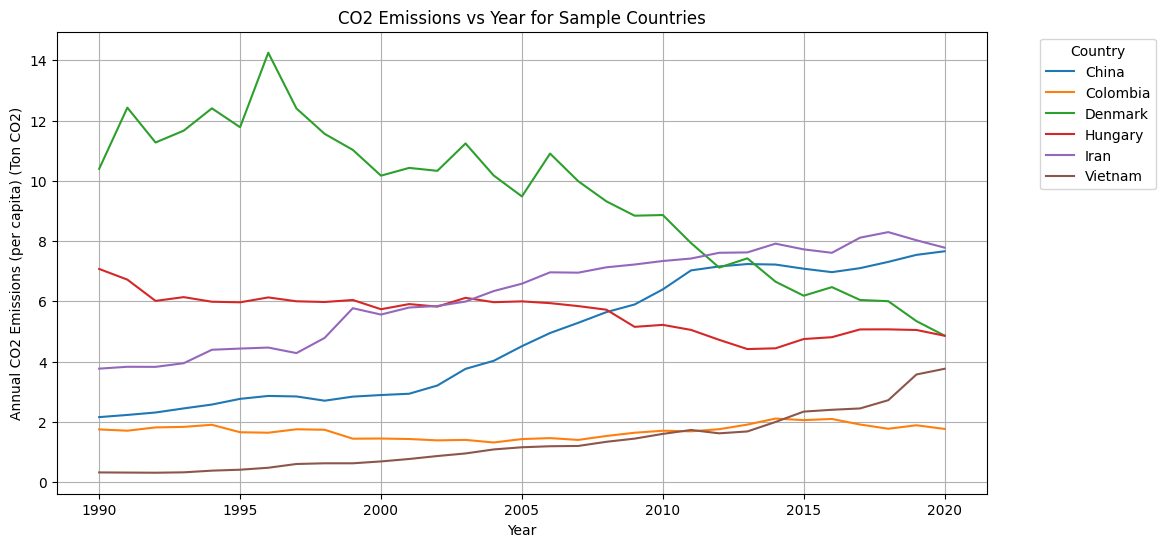

In [43]:
# 1st a Basic Plot, CO2 Emission vs Time

# Starting with a simple plot to visualize the emissions of the sample countries

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_merged_q1, x='Year', y='Annual_CO2', hue='Country')
plt.title('CO2 Emissions vs Year for Sample Countries')
plt.xlabel('Year')
plt.ylabel('Annual CO2 Emissions (per capita) (Ton CO2)')
plt.grid(True)


# Move legend outside the plot
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


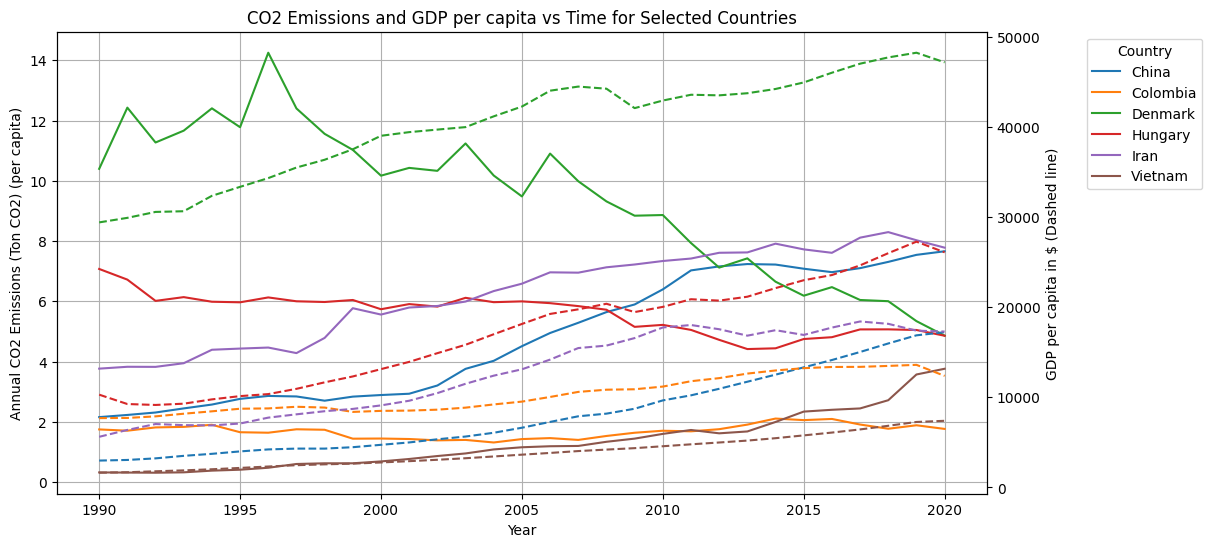

In [44]:
# 2nd Plot - Show a not direct correlation between CO2 Emissions and GDP Plot vs Time

# Plotting GDP alongside the emissions to visualize a possible correlation

# Create the figure and the first axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot CO2 emissions on the first axes
sns.lineplot(data=df_merged_q1, x='Year', y='Annual_CO2', hue='Country', ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Annual CO2 Emissions (Ton CO2) (per capita)')
ax1.grid(True)
ax1.get_legend().remove()

# Create the second axes sharing the same x-axis
ax2 = ax1.twinx()

# Plot GDP per capita on the second axes
sns.lineplot(data=df_merged_q1, x='Year', y='GDP per capita',
             hue='Country', ax=ax2, linestyle='--', legend=False)  # Use dashed lines for GDP
ax2.set_ylabel('GDP per capita in $ (Dashed line)')

# Set the title and legend
plt.title('CO2 Emissions and GDP per capita vs Time for Selected Countries')

# Move legend outside the plot
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, title='Country',
           bbox_to_anchor=(1.1, 1), loc='upper left')

# Show the plot
plt.show()

# Plot shows that emissions and GDP arent correlated at first and can differ greatly from country to country.

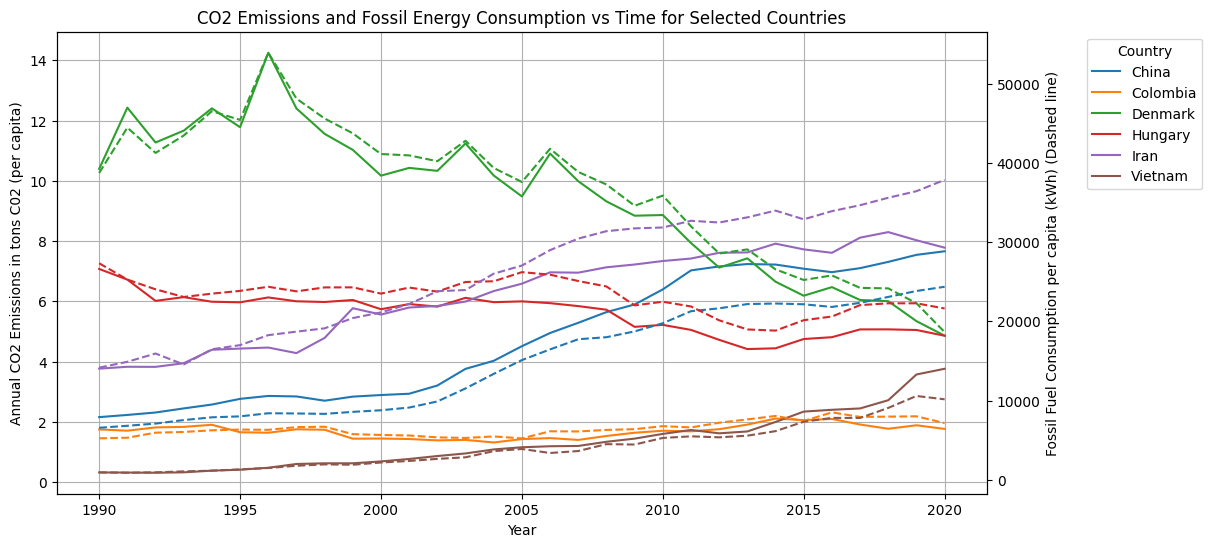

In [45]:
# 3rd Plot - CO2 and Fossil Energy Consumption vs Time

# Show that there is a more direct correlation between energy consumption and CO2 emissions

# Create the figure and the first axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot CO2 emissions on the first axes
sns.lineplot(data=df_merged_q1, x='Year', y='Annual_CO2', hue='Country', ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Annual CO2 Emissions in tons C02 (per capita)')
ax1.grid(True)

# Create the second axes sharing the same x-axis
ax2 = ax1.twinx()

# Plot Fossil Fuel Consumption per capita on the second axes
sns.lineplot(data=df_merged_q1, x='Year', y='Fossil_Cap_kWh', hue='Country', ax=ax2, linestyle='--', legend=False)  # Set legend=False here
ax2.set_ylabel('Fossil Fuel Consumption per capita (kWh) (Dashed line)')

# Set the title and legend for the first axes only
plt.title('CO2 Emissions and Fossil Energy Consumption vs Time for Selected Countries')
ax1.legend(title='Country', bbox_to_anchor=(1.1, 1), loc='upper left')  # Only show legend for ax1

# Show the plot
plt.show()

# The follow the emissions much more closely

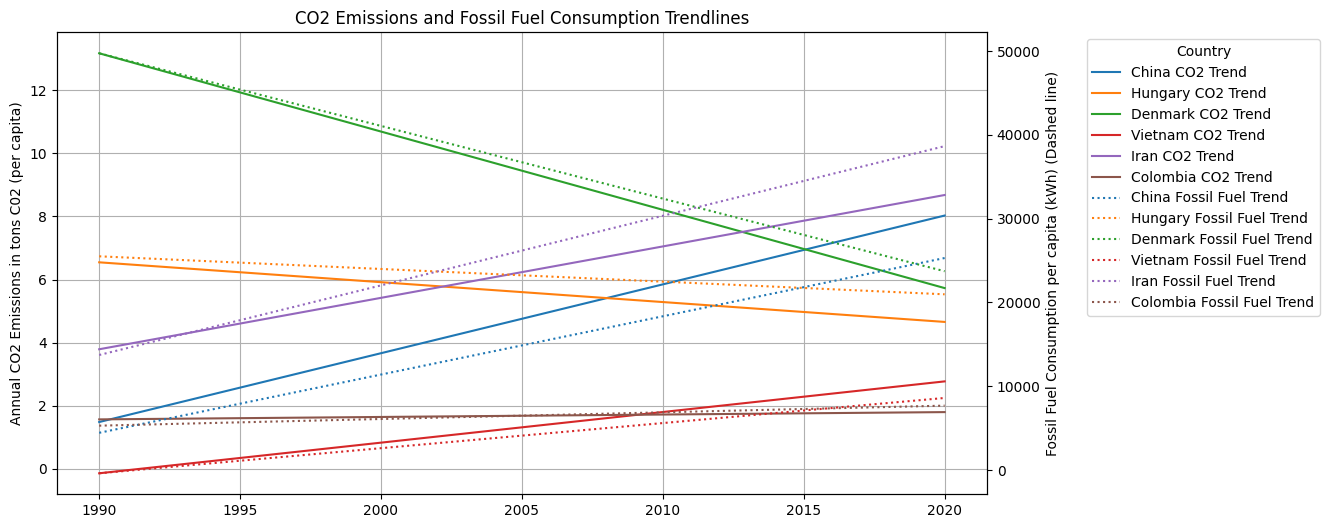

In [46]:
# 4rd Plot - CO2 Emissions and Fossil Fuel Consumption Trendlines vs Time

# To get a better overview we plot the trendlines of the CO2 Emissions and Fuel Consumption

# Create the figure and the first axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.grid(True)

# Add trendlines for CO2 emissions
for country in country_sample2:
    country_data = df_merged_q1[df_merged_q1['Country'] == country]
    x = country_data['Year'].values
    y = country_data['Annual_CO2'].values
    coefficients = np.polyfit(x, y, 1)  # Linear trendline
    trendline = np.poly1d(coefficients)
    ax1.plot(x, trendline(x), linestyle='-', label=f'{country} CO2 Trend')

# Create the second axes sharing the same x-axis
ax2 = ax1.twinx()

# Add trendlines for Fossil Fuel Consumption
for country in country_sample2:
    country_data = df_merged_q1[df_merged_q1['Country'] == country]
    x = country_data['Year'].values
    y = country_data['Fossil_Cap_kWh'].values
    coefficients = np.polyfit(x, y, 1)  # Linear trendline
    trendline = np.poly1d(coefficients)
    ax2.plot(x, trendline(x), linestyle=':', label=f'{country} Fossil Fuel Trend')  # Use dotted lines for Fossil Fuel trend

# Set the title and legends
ax1.set_ylabel('Annual CO2 Emissions in tons C02 (per capita)')
ax2.set_ylabel('Fossil Fuel Consumption per capita (kWh) (Dashed line)')
plt.title('CO2 Emissions and Fossil Fuel Consumption Trendlines')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, title='Country', bbox_to_anchor=(1.1, 1), loc='upper left')

# Show the plot
plt.show()

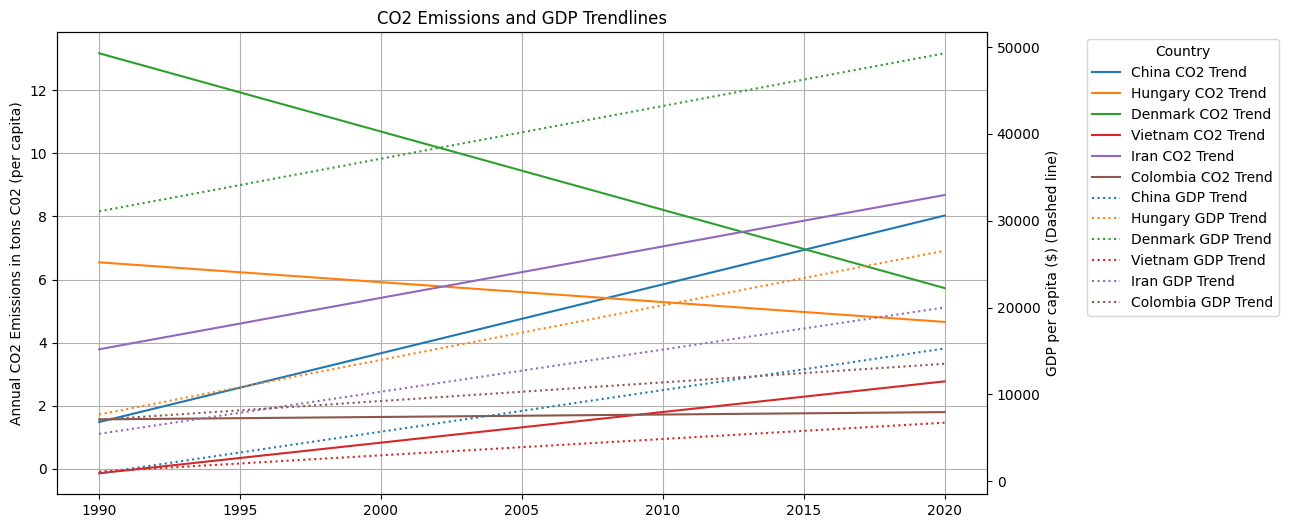

In [47]:
# Plot CO2 Emissions and GDP Trendlines vs Time

# Show the difference that GDP doesnt directly correlate to CO2 emissions

# Create the figure and the first axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot CO2 emissions on the first axes
ax1.grid(True)

# Add trendlines for CO2 emissions
for country in country_sample2:
    country_data = df_merged_q1[df_merged_q1['Country'] == country]
    x = country_data['Year'].values
    y = country_data['Annual_CO2'].values
    coefficients = np.polyfit(x, y, 1)  # Linear trendline
    trendline = np.poly1d(coefficients)
    ax1.plot(x, trendline(x), linestyle='-', label=f'{country} CO2 Trend')

# Create the second axes sharing the same x-axis
ax2 = ax1.twinx()

# Add trendlines for GDP
for country in country_sample2:
    country_data = df_merged_q1[df_merged_q1['Country'] == country]
    x = country_data['Year'].values
    y = country_data['GDP per capita'].values
    coefficients = np.polyfit(x, y, 1)  # Linear trendline
    trendline = np.poly1d(coefficients)
    ax2.plot(x, trendline(x), linestyle=':', label=f'{country} GDP Trend')  # Use dotted lines for GDP trend

# Set the title and legends
plt.title('CO2 Emissions and GDP Trendlines')
ax1.set_ylabel('Annual CO2 Emissions in tons C02 (per capita)')
ax2.set_ylabel('GDP per capita ($) (Dashed line)')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, title='Country', bbox_to_anchor=(1.1, 1), loc='upper left')

# Show the plot
plt.show()

## Question 2 - Which countries are making the biggest strides in decreasing CO2 output?

In [48]:
# Aggregate Data for best strides

df_1990_2020 = df_merged_q2[df_merged_q2['Year'].isin([1990, 2020])]

# Pivot the table to have years as columns
df_pivot = df_1990_2020.pivot(index='Country', columns='Year', values='Share_Renewable')

#display(df_pivot)

## Portugal, North Macedonia, Philippines miss 1990, fill in manually from merged_df first given datapoint
# display(merged_df.loc[merged_df['Country'] == 'North Macedonia'])
df_pivot.loc['Portugal', 1990] = 17.54
df_pivot.loc['North Macedonia', 1990] = 8.87
df_pivot.loc['Philippines', 1990] = 8.32

# Calculate the difference between 2020 and 1990
df_pivot['Stride'] = (df_pivot[2020] - df_pivot[1990]).astype(float).round(2)
df_pivot = df_pivot.sort_values(by=['Stride'], ascending=False)

top5_countries = df_pivot.head(5)
bottom5_countries = df_pivot.tail(10)

display(top5_countries)
display(bottom5_countries)

# Note that when we fill in the later datapoints their strides get skewed a bit.


Year,1990,2020,Stride
Country,,,
Denmark,0.94,29.77,28.83
Romania,4.59,25.39,20.80
Ukraine,7.74,25.62,17.88
Ireland,1.75,19.24,17.49
Ecuador,18.21,35.43,17.22


Year,1990,2020,Stride
Country,,,
Thailand,4.10,2.56,-1.54
Vietnam,20.58,18.47,-2.11
Pakistan,16.93,14.16,-2.77
Bangladesh,3.54,0.67,-2.87
Philippines,8.32,5.30,-3.02
Japan,15.71,11.33,-4.38
Colombia,32.31,26.53,-5.78
New Zealand,38.57,32.51,-6.06
Taiwan,19.21,8.49,-10.72


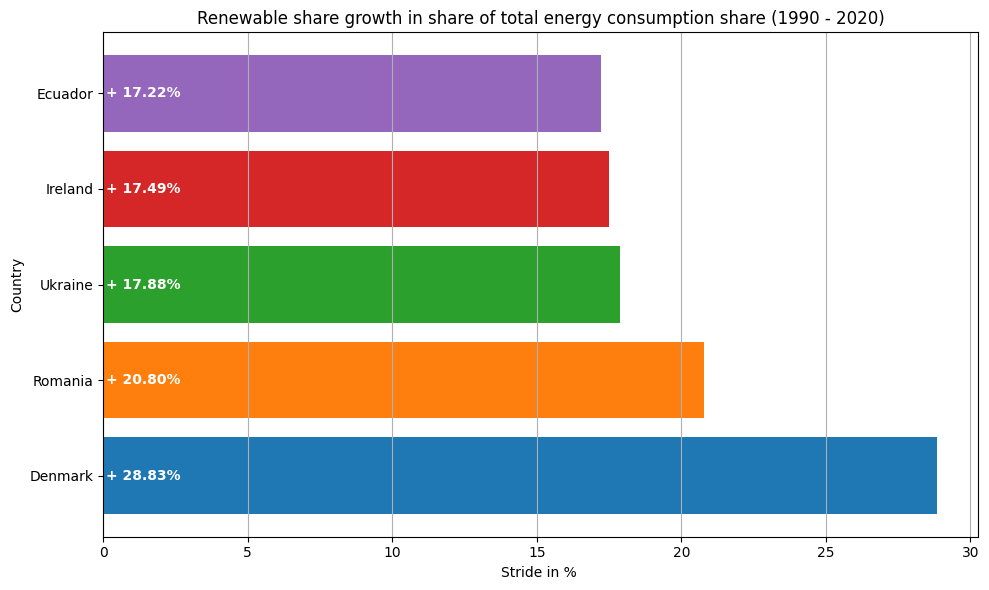

In [49]:
# Create the horizontal bar chart

# Stride from 1990 - 2020

plt.figure(figsize=(10, 6))

# Iterate through countries and apply styles
for country in top5_countries.index:
    # Get the stride value
    stride_value = top5_countries.loc[country, 'Stride']

    # Plot the horizontal bar
    plt.barh(country, stride_value)

    # Add the value as text inside the bar
    plt.text(0.1, country, f'+ {stride_value:.2f}%',
             va='center', ha='left', color='white', fontweight='bold', fontsize=10)

plt.title('Renewable share growth in share of total energy consumption share (1990 - 2020)')
plt.xlabel('Stride in % ')
plt.ylabel('Country')
plt.grid(axis='x')

plt.tight_layout()
plt.show()

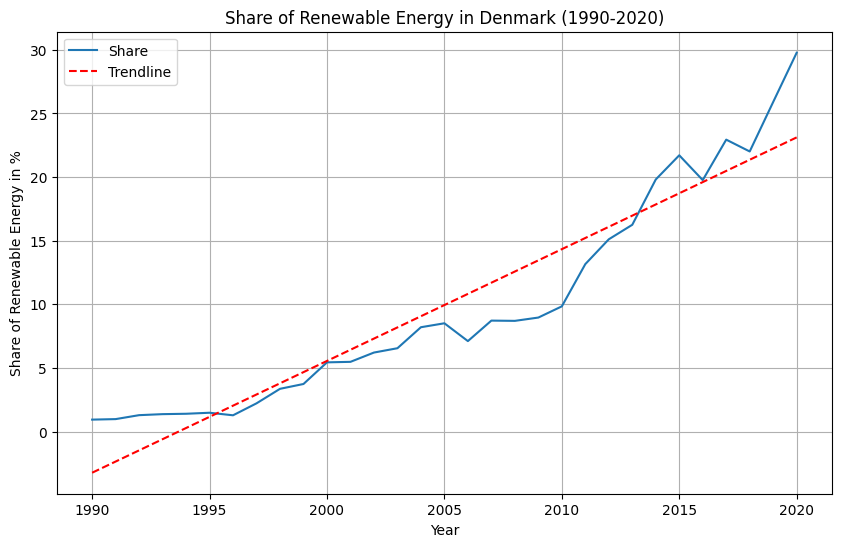

In [50]:
# Small plotting trend - Share Renewable Energy NL

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_Denmark, x='Year', y='Share_Renewable', label='Share')
plt.title('Share of Renewable Energy in Denmark (1990-2020)')
plt.xlabel('Year')
plt.ylabel('Share of Renewable Energy in %')
plt.grid(True)

# Add trendline
x = df_Denmark['Year'].values
y = df_Denmark['Share_Renewable'].values
coefficients = np.polyfit(x, y, 1)  # Linear trendline (degree 1)
trendline = np.poly1d(coefficients)

#print(trendline)
plt.plot(x, trendline(x), color='red', linestyle='--', label='Trendline')
plt.legend() # Show legend to display the trendline label
plt.show()

# Show small loss of detail because the share only shows the trendline of the share

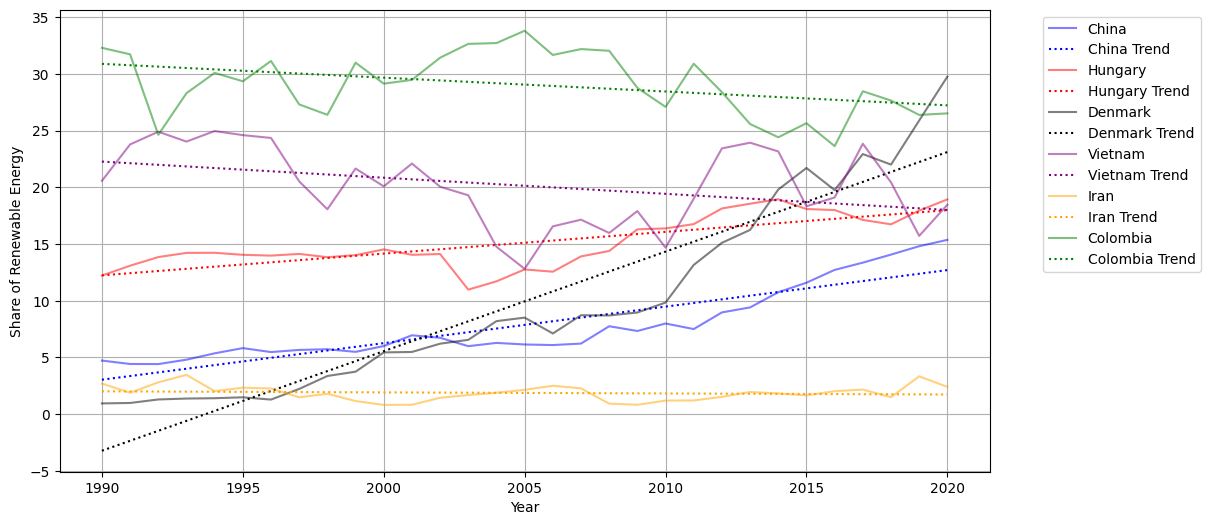

In [51]:
# Renewable Trendlines to show loss of detail

plt.figure(figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Share of Renewable Energy')

plt.grid(True)

# Define a dictionary to map countries to colors and linestyles
country_styles = {
    'China': {'color': 'blue', 'linestyle': ':'},
    'Hungary': {'color': 'red', 'linestyle': ':'},
    'Denmark': {'color': 'black', 'linestyle': ':'},
    'Vietnam': {'color': 'purple', 'linestyle': ':'},
    'Iran': {'color': 'orange', 'linestyle': ':'},
    'Colombia': {'color': 'green', 'linestyle': ':'}}

# Iterate through countries and apply styles
for country in country_sample2:
    country_data = df_merged_q2[df_merged_q2['Country'] == country]

    # Get color and linestyle from the dictionary
    style = country_styles[country]

    # Plot the actual data
    sns.lineplot(data=country_data, x='Year', y='Share_Renewable',
                 color=style['color'], label=country, alpha=0.5)

    # Calculate and plot the trendline with the same style
    x = country_data['Year'].values
    y = country_data['Share_Renewable'].values
    coefficients = np.polyfit(x, y, 1)
    trendline = np.poly1d(coefficients)
    plt.plot(x, trendline(x), color=style['color'],
             linestyle=style['linestyle'], label=f'{country} Trend')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Show that their is a loss of detailed information because we can now only see the general direction countries are going

## Question 3 - Which non-fossil fuel energy technology will have the best price in the future?

    Region                         Technology    Data Type  Year       Value
95   World                       Solar energy  Capacity MW  2023  1418008.17
143  World                        Wind energy  Capacity MW  2023  1017390.45
191  World  Hydropower (excl. pumped storage)  Capacity MW  2023  1264741.54
239  World                      Marine energy  Capacity MW  2023      508.12
287  World                          Bioenergy  Capacity MW  2023   148840.07
335  World                  Geothermal energy  Capacity MW  2023    15025.75


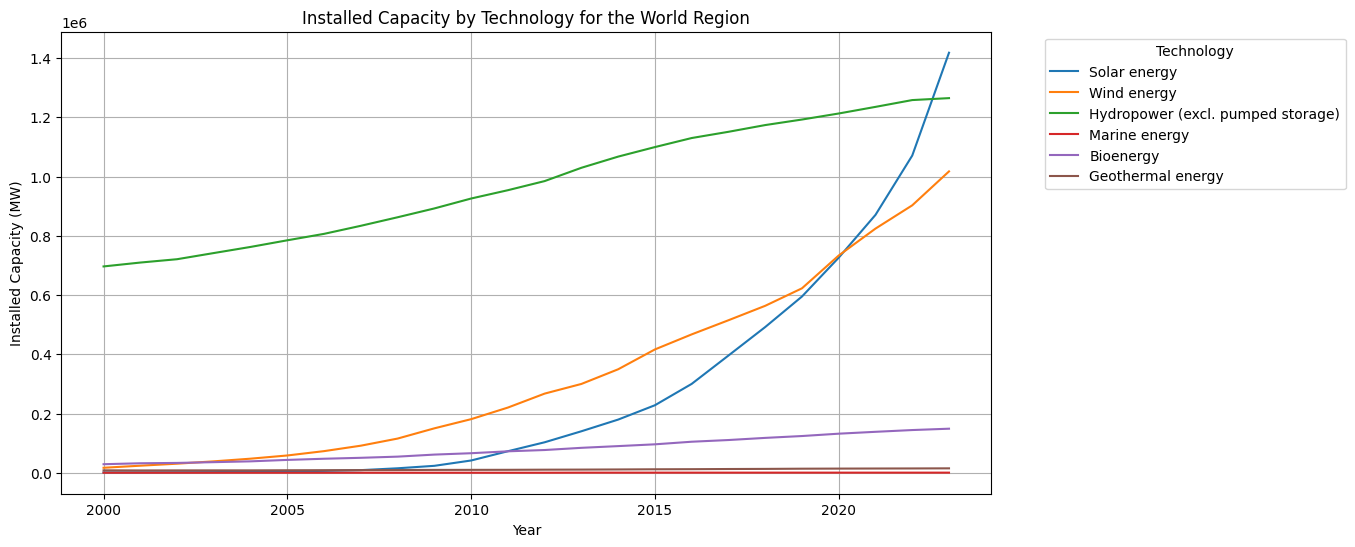

In [52]:
# Lineplot for the world region with installed capacity per year for each techonology

# Filter data for the world region
world_data = df_statistics[df_statistics['Region'] == 'World']
last_year_data = world_data[world_data['Year'] == world_data['Year'].max()]

# Create the line plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.lineplot(data=world_data, x='Year', y='Value', hue='Technology')
plt.title('Installed Capacity by Technology for the World Region')
plt.xlabel('Year')
plt.ylabel('Installed Capacity (MW)')
plt.grid(True)
plt.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left')

print(last_year_data)
plt.show()

Predicted installed capacity for 2030: 1152530.71 MW


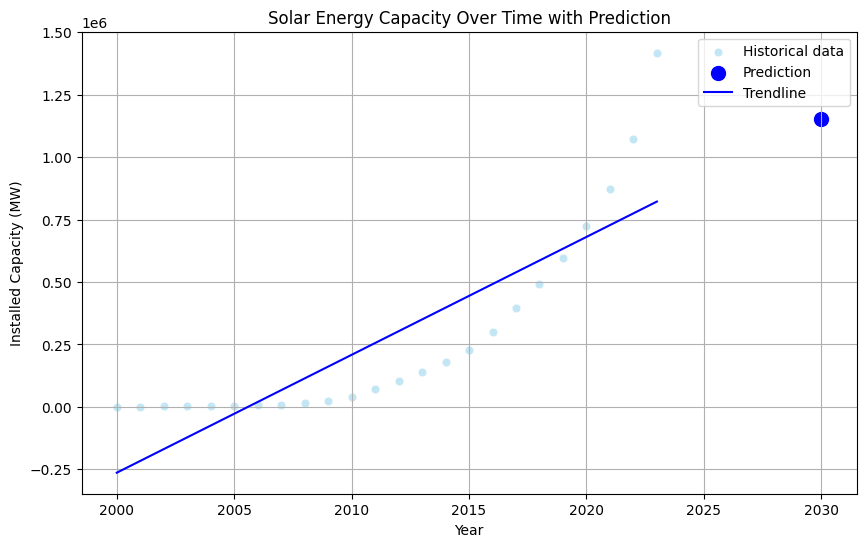

In [53]:
# First simple model and plot to predict solar


# Filter data for the world region and specific technology (e.g., Solar energy)
technology_data = df_statistics[(df_statistics['Region'] == 'World') & (df_statistics['Technology'] == 'Solar energy')]

# Extract the year and capacity values
X = technology_data[['Year']]  # Features (independent variable)
y = technology_data['Value']  # Target (dependent variable)

# Create a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X, y)

# Create a new data point for 2030
future_year = pd.DataFrame([[2030]], columns=['Year'])

# Predict the capacity
predicted_capacity = model.predict(future_year)

print(f"Predicted installed capacity for 2030: {predicted_capacity[0]:.2f} MW")

# Create the scatter plot for historical data
plt.figure(figsize=(10, 6))

sns.scatterplot(data=technology_data, x='Year', y='Value', alpha=0.5, label ='Historical data', color='skyblue')
plt.title('Solar Energy Capacity Over Time with Prediction')
plt.xlabel('Year')
plt.ylabel('Installed Capacity (MW)')
plt.grid(True)

# Plot the prediction for 2030
plt.scatter(future_year['Year'], predicted_capacity, color='blue', marker='o', s=100, label='Prediction')

# Add a trendline
plt.plot(X, model.predict(X), color='blue', linestyle='-', label='Trendline')

plt.legend()
plt.show()


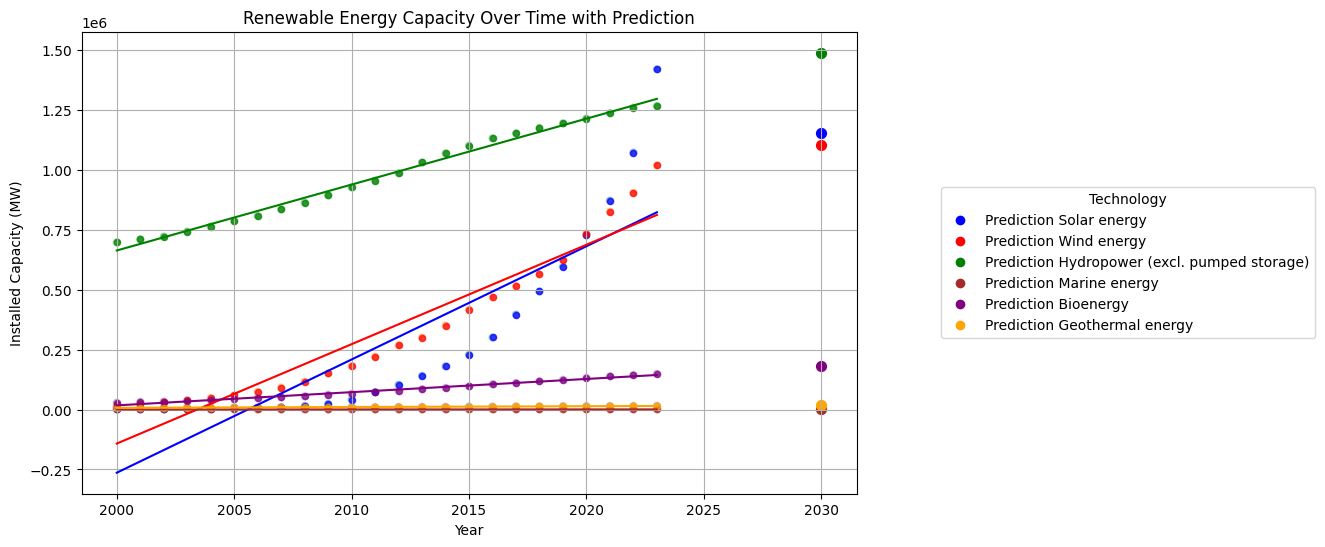

,Technology,Predicted Capacity (MW)
0,Hydropower (excl. pumped storage),1487151.09
1,Solar energy,1152530.71
2,Wind energy,1101026.52
3,Bioenergy,182427.94
4,Geothermal energy,16991.68
5,Marine energy,681.08


In [54]:
# Final Plot With all Regression

# Filter data for the world region and specific technologies
technologies = ['Solar energy', 'Wind energy', 'Hydropower (excl. pumped storage)',
               'Marine energy', 'Bioenergy', 'Geothermal energy']
technology_data = df_statistics[
    (df_statistics['Region'] == 'World') & (df_statistics['Technology'].isin(technologies))]

# Define colors for each technology
technology_colors = {
    'Solar energy': 'blue',
    'Wind energy': 'red',
    'Hydropower (excl. pumped storage)': 'green',
    'Marine energy': 'brown',
    'Bioenergy': 'purple',
    'Geothermal energy': 'orange'}

# Create the scatter plot for historical data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=technology_data, x='Year', y='Value', hue='Technology', alpha=0.5, legend=False)   #Remove legend for readability
plt.title('Renewable Energy Capacity Over Time with Prediction')
plt.xlabel('Year')
plt.ylabel('Installed Capacity (MW)')
plt.grid(True)

# We choose linear regression model
model = LinearRegression()

# Dictionary to store predicted values
capacity_list = {}  # Initialize the dictionary

# We predict the value by fitting the model to each technology
for technology in technologies:
    # Filter data for the specific technology
    tech_data = technology_data[technology_data['Technology'] == technology]

    # Get the color for the current technology
    color = technology_colors[technology]

    # Extract the year and capacity values
    X = tech_data[['Year']]
    y = tech_data['Value']

    # Train the model
    model.fit(X, y)

    # Create a new data point for 2030
    future_year = pd.DataFrame([[2030]], columns=['Year'])

    # Predict the capacity
    predicted_capacity = model.predict(future_year)
    capacity_list[technology] = predicted_capacity[0]  # Store predicted value in the dictionary
    # Plot the values with the assigned color
    plt.scatter(tech_data['Year'], tech_data['Value'], marker='o', s=20, color=color, alpha=0.7)

    # Plot the prediction for 2030 with the assigned color
    plt.scatter(future_year['Year'], predicted_capacity, marker='o', s=50, color=color)

    # Add a trendline with the assigned color
    plt.plot(X, model.predict(X), linestyle='-', color=color)

# Create custom legend elements and labels
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=technology_colors[technology],
                              markersize=8,  label=f'Prediction {technology}') for technology in technologies]

# Add the legend to the plot
plt.legend(handles=legend_elements, title='Technology', bbox_to_anchor=(1.1, 0.5), loc='center left')

plt.show()

#Unpacking unto a readable list for the datframe
items_list = [*capacity_list.items()]

#Dataframe with predictions
predicted_df = pd.DataFrame(items_list, columns=['Technology', 'Predicted Capacity (MW)'])

# Sort and index the predicted capacity in descending order
predicted_df = predicted_df.sort_values(by=['Predicted Capacity (MW)'], ascending=False)
predicted_df['Predicted Capacity (MW)'] = predicted_df['Predicted Capacity (MW)'].round(2)
predicted_df = predicted_df.reset_index(drop=True)

display(predicted_df)

# Note that we dont have a large dataset, this means this regression is over simplified. Normally a much larger dataset should be used.
# The more you go into the future, the more cloudy the predictions get
# We can argue that even to hydro has a large capacity its use is limited, and geographically bound to certain countries